In [22]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import pyplot as plt
from matplotlib import colors

from neutronMS import MS_sim, GEN_constQgeom

In [23]:
#geom = ('anular', 1.1, 1.3, 4)
geom = ('cuboid', 1, 4, 4)

mus=(1,.1)
S_files = ('./data_Sq/Sqw_test/S_mesh.npy', './data_Sq/Sqw_test/Q_mesh.npy', './data_Sq/Sqw_test/omega_mesh.npy')

## Test of the MS_sim class

In [24]:
ki=5.8
kf=5.8
theta=1

In [25]:
sim = MS_sim(geom, ki, kf, theta, mus, S_files)
sim.run(N=100000, N_bunch=40)

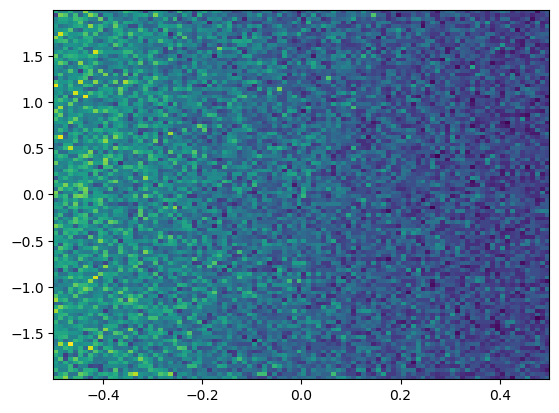

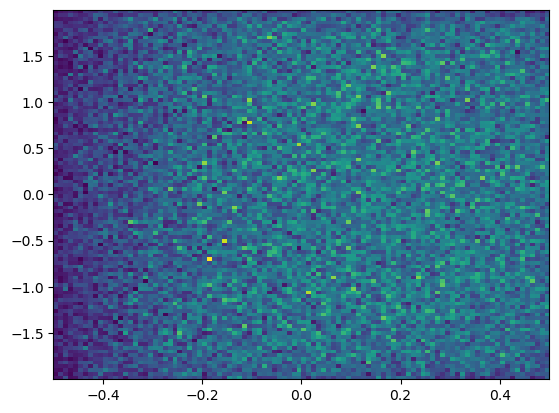

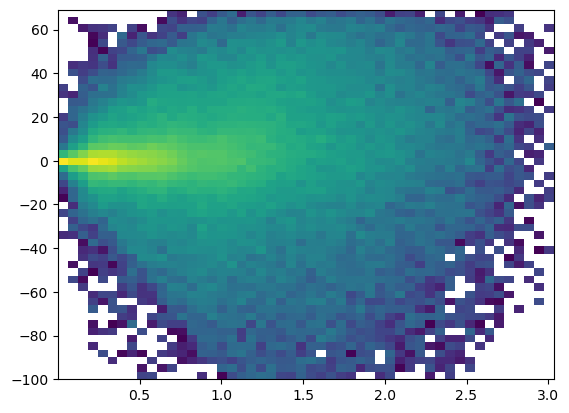

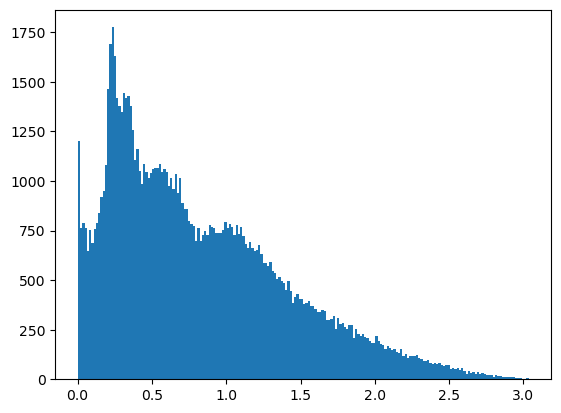

In [26]:
plt.figure()
plt.hist2d(sim.p1[:,0], sim.p1[:,1], bins=100, weights=sim.w1)
plt.figure()
plt.hist2d(sim.p2[:,0], sim.p2[:,1], bins=100, weights=sim.w2)

plt.figure()
plt.hist2d(sim.theta1m, sim.omega1m, weights=sim.wfs, norm=colors.LogNorm(), bins=50);
plt.figure()
plt.hist(sim.theta1m, bins=200);

## Loop usage example

In [27]:
######################################
kf = 5.8
omega = np.arange(-30, 30, 1)
Q = 1.5
######################################

data = GEN_constQgeom('inverse', 5.8, Q, omega)

for i in data.index:
    sim = MS_sim(geom, data.ki.loc[i], data.kf.loc[i], data.theta.loc[i], mus, S_files)
    sim.run(N=100000, N_bunch=40)
    data.loc[i,'Is'] = sim.Is
    data.loc[i,'Im'] = sim.Im


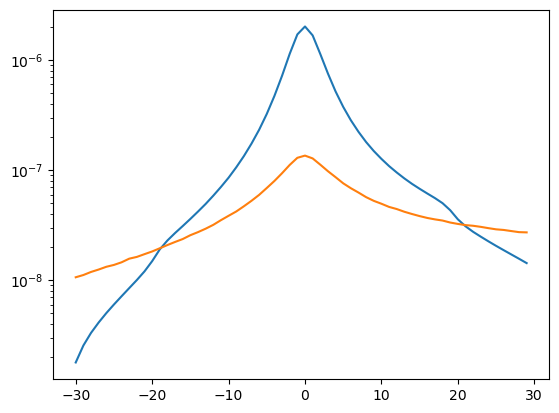

In [28]:
plt.plot(data.omega, data.Is)
plt.plot(data.omega, data.Im)

plt.yscale('log')

#plt.savefig('anular 11, 13')

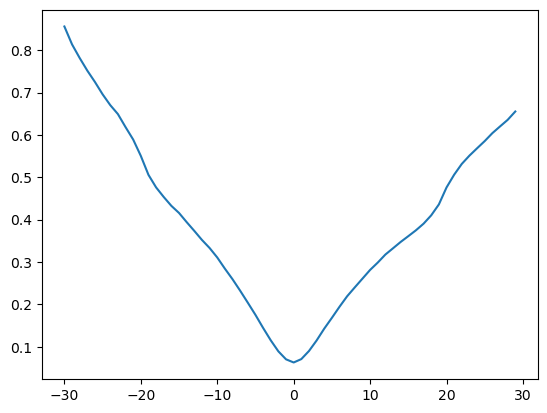

In [29]:
plt.plot(data.omega, data.Im/(data.Is+data.Im))